### 라이브러리 import 및 데이터 불러오기
* 데이터 선정 이유
* 문제 정의



In [202]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension
!pip install eli5
!pip install shap
!pip install PDPbox

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score,accuracy_score,plot_confusion_matrix,classification_report,f1_score, make_scorer, recall_score, roc_curve, roc_auc_score

In [204]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# target label 설정 (해약한다 / 안한다)
target = 'Churn'

# customerID feature는 삭제
df = df.drop('customerID', axis=1)

# Total Charges, Monthly Charges는 숫자형으로 변경
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

In [205]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [206]:
# 결측치
null_index = df[df['TotalCharges'].isnull()].index

# Total Charges의 결측치는 Monthly Charges * Tenure month로 계산
df['TotalCharges'].iloc[null_index] = df['MonthlyCharges'].iloc[null_index] * df['tenure'].iloc[null_index]

# 데이터를 이용한 가설 및 평가지표, 베이스라인 선택
* 해당 특성을 target으로 지정한 이유를 설명하세요
* 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명하세요

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

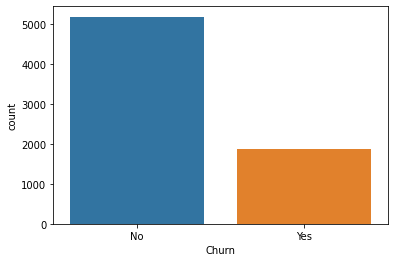

In [207]:
# 타겟 데이터 범주의 비율 확인
sns.countplot(data=df, x=target);

df[target].value_counts(normalize=True)
# 'No'가 73% 정도로 살짝 imbalanced data인 것을 확인할 수 있다. 
# => accuaracy score만으로는 정확하지 않을 수 있기 때문에 precision, recall, f1-score 평가지표를 사용한다.

In [330]:
# Baseline

# 최빈값
major = df[target].mode()[0]
y_pred_base = [major] * len(df[target])
print("baseline accuracy: ", accuracy_score(df[target], y_pred_base))
print(f'baseline f2: {fbeta_score(df[target], y_pred_base, 2, pos_label="Yes")}')

baseline accuracy:  0.7346301292063041
baseline f2: 0.0


In [332]:
print(classification_report(df[target], y_pred_base))


              precision    recall  f1-score   support

          No       0.73      1.00      0.85      5174
         Yes       0.00      0.00      0.00      1869

    accuracy                           0.73      7043
   macro avg       0.37      0.50      0.42      7043
weighted avg       0.54      0.73      0.62      7043



**가설**

* Contract Type에 따라 Churn 비율이 다를 것이다. => 짧을 수록 해지율이 높다



**평가지표**

True Yes/Predicted No (False Negative)를 줄여야함 => Recall에 가중치를 더 주는 f2-score 사용

# EDA와 데이터 전처리

태스크를 수행한 후, 다음 질문에 대답할 수 있어야 합니다
* Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?

* 박소영님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

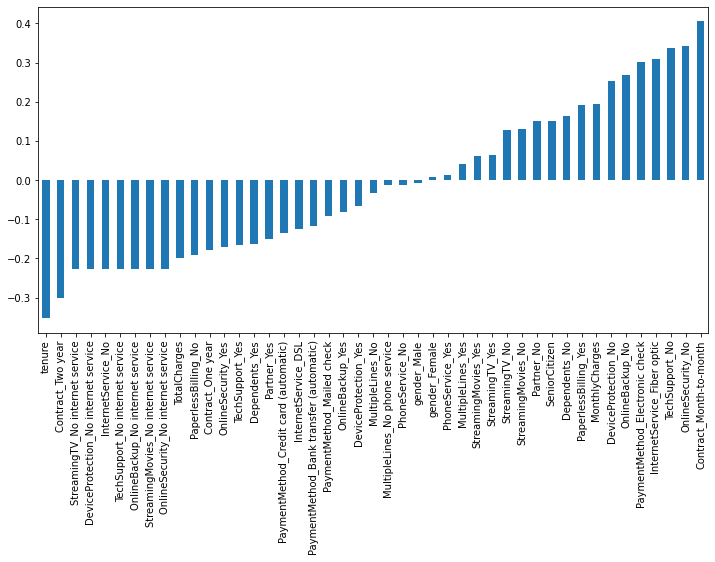

In [209]:
# one hot encoding 진행
enc = OneHotEncoder(use_cat_names=True)
df_encoded = enc.fit_transform(df)

# Churn Yes와 높은 상관 관계를 가지는 feature 확인하기
correlation = df_encoded.corr()['Churn_Yes'].sort_values(ascending=True)[1:-1]
plt.figure(figsize=(12,6))
correlation.plot.bar();

**해지하는 데 있어 가장 높은 영향을 끼치는 top 3 feature**


1.   Contract: Month to Month
2.   Online Security: No
3.   Tech Support: No

**해지하지 않는 데 가장 높은 영향을 끼치는 top 3 feature**
1. Tenure
2. Contract: Two year
3. Streaming TV: No internet Service

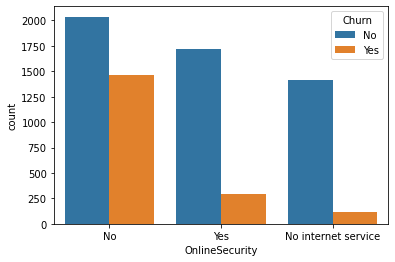

In [324]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='OnlineSecurity',hue='Churn');

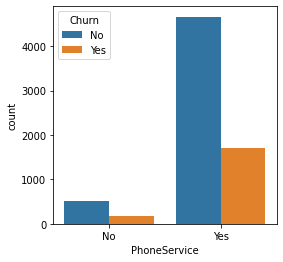

In [326]:
plt.figure(figsize=(4,4))
sns.countplot(data=df,x='PhoneService',hue='Churn');

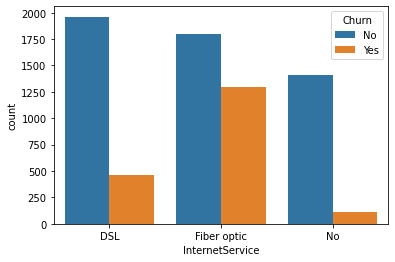

In [327]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='InternetService',hue='Churn');

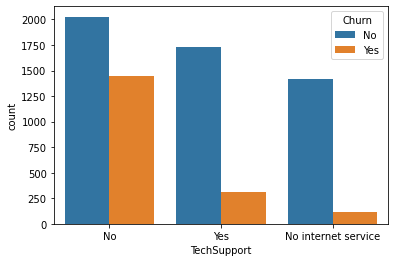

In [328]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='TechSupport',hue='Churn');

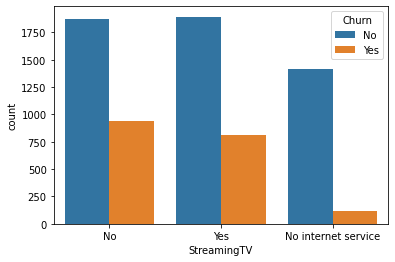

In [329]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='StreamingTV',hue='Churn');

In [357]:
i = df[['InternetService','MonthlyCharges']]
i.groupby('InternetService').mean()

,MonthlyCharges
InternetService,
DSL,58.102169
Fiber optic,91.500129
No,21.079194


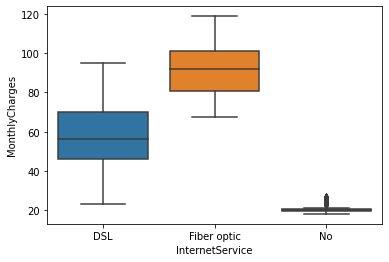

In [363]:
sns.boxplot(data=i, y=i['MonthlyCharges'], x=i['InternetService']);

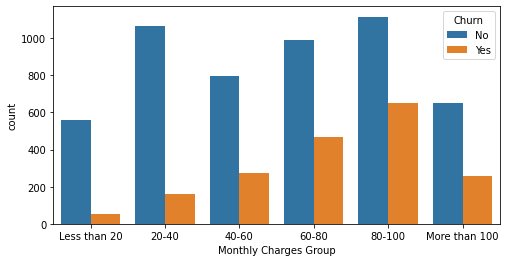

In [375]:
def group_monthly(monthly):
  if monthly < 20:
    return 'Less than 20'
  elif monthly < 40:
    return '20-40'
  elif monthly < 60:
    return '40-60'
  elif monthly < 80:
    return '60-80'
  elif monthly < 100:
    return '80-100'
  else:
    return 'More than 100'

df['Monthly Charges Group'] = df['MonthlyCharges'].apply(group_monthly)

# tenure year 그룹 별 해약 여부 그래프
plt.figure(figsize=(8,4))
sns.countplot(data=df,x='Monthly Charges Group',hue='Churn', order=['Less than 20', '20-40', '40-60', '60-80', '80-100', 'More than 100']);

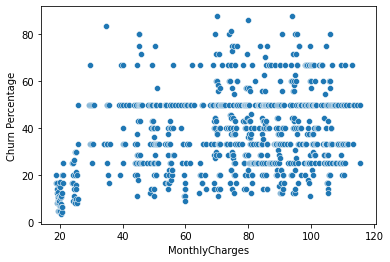

In [369]:
# tenure의 value별로 데이터를 나눈다
no_by_monthly = df.groupby(['Churn','MonthlyCharges']).count().transpose()['No']
yes_by_monthly = df.groupby(['Churn','MonthlyCharges']).count().transpose()['Yes']

# tenure 값에 따른 해약율
churn_percentage = 100 * yes_by_monthly / (no_by_monthly+yes_by_monthly)
churn_by_monthly = churn_percentage.iloc[0][1:].rename('Churn Percentage')

sns.scatterplot(data=churn_by_monthly);

# tenure가 길수록 해약율이 낮다

### Tenure

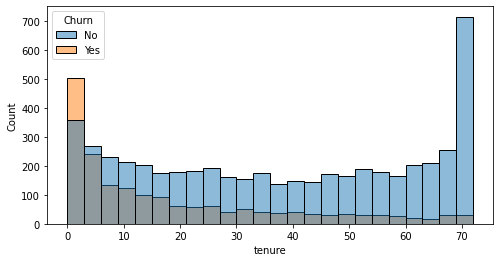

In [343]:
plt.figure(figsize=(8,4))
sns.histplot(data=df,x='tenure',bins=24, hue='Churn');


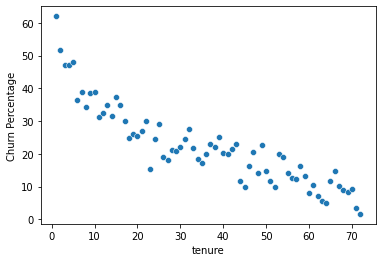

In [210]:
# tenure의 value별로 데이터를 나눈다
no_by_tenure = df.groupby(['Churn','tenure']).count().transpose()['No']
yes_by_tenure = df.groupby(['Churn','tenure']).count().transpose()['Yes']

# tenure 값에 따른 해약율
churn_percentage = 100 * yes_by_tenure / (no_by_tenure+yes_by_tenure)
churn_by_tenure = churn_percentage.iloc[0][1:].rename('Churn Percentage')

sns.scatterplot(data=churn_by_tenure);

# tenure가 길수록 해약율이 낮다

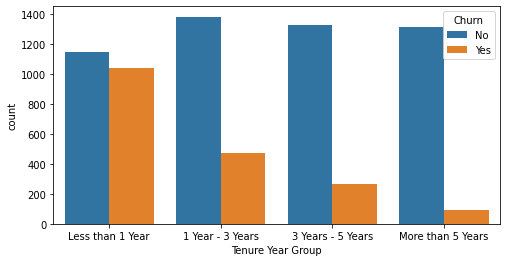

In [211]:
# tenure를 year별로 그룹을 새로 만들어 feature를 추가

# Less than 1 Year
# 1 Year - 3 Years
# 3 Years - 5 Years
# More than 5 Years


def group_tenure(tenure):
  if tenure < 13:
    return 'Less than 1 Year'
  elif tenure < 37:
    return '1 Year - 3 Years'
  elif tenure < 61:
    return '3 Years - 5 Years'
  else:
    return 'More than 5 Years'

df['Tenure Year Group'] = df['tenure'].apply(group_tenure)

# tenure year 그룹 별 해약 여부 그래프
plt.figure(figsize=(8,4))
sns.countplot(data=df,x='Tenure Year Group',hue='Churn');

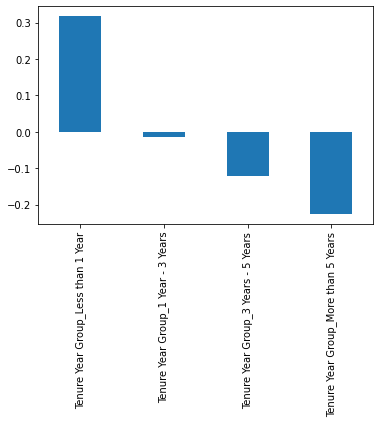

In [212]:
# one hot encoding 진행
tenure_year = df[['Tenure Year Group', 'Churn']]
enc = OneHotEncoder(use_cat_names=True)
tenure_year_encoded = enc.fit_transform(tenure_year)

# Tenure Year Group 별 Churn_Yes와의 상관관계
tenure_year_encoded.corr()['Churn_Yes'].sort_values(ascending=False)[1:-1].plot.bar();

### Contract Type
가설: Contract Type에 따라 Churn 비율이 다를 것이다. => 짧을 수록 해지율이 높다

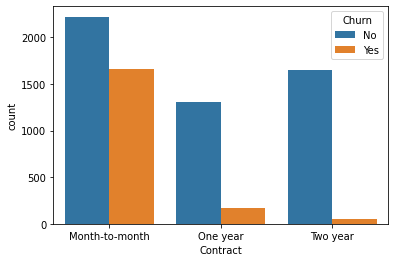

In [323]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x='Contract',hue='Churn');

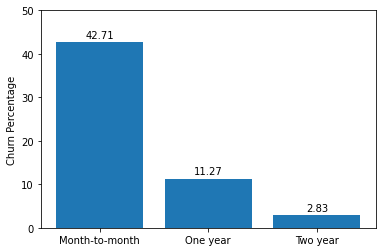

In [213]:
# Contract value별로 데이터를 나눈다
no_by_contract = df.groupby(['Churn','Contract']).count().transpose()['No']
yes_by_contract = df.groupby(['Churn','Contract']).count().transpose()['Yes']

# Contract 값에 따른 해약율
churn_percentage = 100 * yes_by_contract / (no_by_contract+yes_by_contract)
churn_by_contract = churn_percentage.iloc[0].rename('Churn Percentage')

plt.bar(x=churn_by_contract.index, height=churn_by_contract.values);
plt.ylim(top=50)
plt.ylabel('Churn Percentage')
for i, v in enumerate(churn_by_contract.values):
    plt.text(i, v+1, "%.2f" %v, ha="center")

# 머신러닝 방식 적용 및 교차검증

* 모델을 학습한 후에 베이스라인보다 잘 나왔나요? 그렇지 않다면 그 이유는 무엇일까요?
* 모델 성능 개선을 위해 어떤 방법을 적용했나요? 그 방법을 선택한 이유는 무엇인가요?
* 최종 모델에 관해 설명하세요.

### Train/Test/Validation Split

In [214]:
X = df.drop(target,axis=1)
y = df[target]

# 70% of data is training data, set aside other 30%
X_train, X_OTHER, y_train, y_OTHER = train_test_split(X, y, test_size=0.3, random_state=101)

# Remaining 30% is split into evaluation and test sets
# Each is 15% of the original data size
X_val, X_test, y_val, y_test = train_test_split(X_OTHER, y_OTHER, test_size=0.5, random_state=101)


### Adaboost

In [346]:
df.select_dtypes(exclude='float')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,Tenure Year Group
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,Less than 1 Year
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,1 Year - 3 Years
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,Less than 1 Year
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,3 Years - 5 Years
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,Less than 1 Year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No,1 Year - 3 Years
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No,More than 5 Years
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,Less than 1 Year
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,Less than 1 Year


In [286]:
onehot = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod', 'Contract']
ordinal = ['Tenure Year Group']

              precision    recall  f1-score   support

          No       0.82      0.91      0.86       751
         Yes       0.69      0.50      0.58       305

    accuracy                           0.79      1056
   macro avg       0.75      0.70      0.72      1056
weighted avg       0.78      0.79      0.78      1056

AdaBoost: f1 0.5795454545454546
AdaBoost: f2 0.5301455301455301


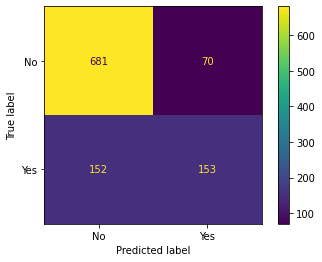

In [351]:
ada_pipe = make_pipeline(
    OneHotEncoder(cols = onehot, use_cat_names=True),
    OrdinalEncoder(cols=ordinal),
    AdaBoostClassifier()
)
ada_pipe.fit(X_train, y_train)
ada_val_preds = ada_pipe.predict(X_val)
print(classification_report(y_val, ada_val_preds))
plot_confusion_matrix(ada_pipe,X_val,y_val, values_format = 'd');

print(f'AdaBoost: f1 {f1_score(y_val, ada_val_preds, pos_label="Yes")}')
print(f'AdaBoost: f2 {fbeta_score(y_val, ada_val_preds, 2, pos_label="Yes")}')

AUC score:  0.8409530462116086


Text(0, 0.5, 'TPR')

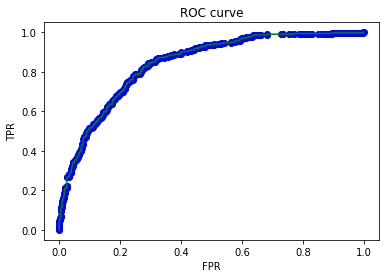

In [289]:
y_pred_proba = ada_pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba, pos_label="Yes")
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### AdaBoost with GridSearch

In [244]:
# score metric 정의
# scoring = {'accuracy': make_scorer(accuracy_score),
#            'f2_scorer': make_scorer(fbeta_score, beta=2, pos_label="Yes"),
#            'recall': 'recall'}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label="Yes")

In [219]:
# pipe = make_pipeline(
#     OneHotEncoder(use_cat_names=True),
#     AdaBoostClassifier()
# )

# parameters = {'adaboostclassifier__n_estimators':[50, 500, 1000, 1500], 
#              'adaboostclassifier__learning_rate':[0.05, 0.1, 0.2, 0.5, 1]}

# grid = GridSearchCV(pipe, parameters, n_jobs=-1, cv=5, scoring=f2_scorer)

# grid.fit(X_train, y_train)


`grid.best_params_` 가 learning_rate: 1, n_estimators: 50으로 default 밸류와 같아 gridsearchCV는 코멘트아웃 처리 하였다.

### Decision Tree

              precision    recall  f1-score   support

          No       0.79      0.80      0.79       751
         Yes       0.49      0.46      0.47       305

    accuracy                           0.70      1056
   macro avg       0.64      0.63      0.63      1056
weighted avg       0.70      0.70      0.70      1056

DT 검증 정확도:  0.7045454545454546
DT: f2 0.46449900464499005


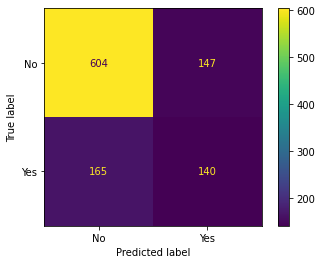

In [291]:
dt = make_pipeline(
    OneHotEncoder(cols = onehot, use_cat_names=True),
    OrdinalEncoder(cols=ordinal), 
    DecisionTreeClassifier(class_weight='balanced', random_state=2)
)

dt.fit(X_train, y_train)

dt_preds = dt.predict(X_val)
print(classification_report(y_val,dt_preds))
plot_confusion_matrix(dt,X_val,y_val, values_format = 'd')

print('DT 검증 정확도: ', dt.score(X_val, y_val))

print(f'DT: f2 {fbeta_score(y_val, dt_preds, 2, pos_label="Yes")}')

AUC score:  0.6418021872476043


Text(0, 0.5, 'TPR')

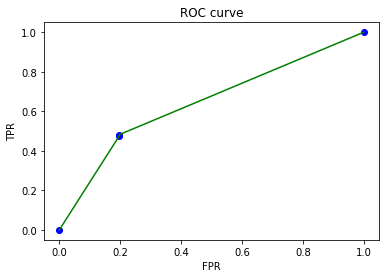

In [247]:
y_pred_proba = dt.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba, pos_label="Yes")
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### Decision Tree with GridSearch

In [292]:
dt_params={
    'decisiontreeclassifier__min_samples_split' : range(10,100,10),
    'decisiontreeclassifier__max_depth': range(3,20,5),
    }

dt_grid = GridSearchCV(dt, dt_params, n_jobs=-1, cv=5, scoring='accuracy')

dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('onehotencoder',
                                        OneHotEncoder(cols=['gender', 'Partner',
                                                            'Dependents',
                                                            'PhoneService',
                                                            'MultipleLines',
                                                            'InternetService',
                                                            'OnlineSecurity',
                                                            'OnlineBackup',
                                                            'DeviceProtection',
                                                            'TechSupport',
                                                            'StreamingTV',
                                                            'StreamingMovies',
            

In [293]:
dt_grid.best_params_

{'decisiontreeclassifier__max_depth': 3,
 'decisiontreeclassifier__min_samples_split': 10}

              precision    recall  f1-score   support

          No       0.89      0.74      0.81       751
         Yes       0.55      0.78      0.64       305

    accuracy                           0.75      1056
   macro avg       0.72      0.76      0.72      1056
weighted avg       0.79      0.75      0.76      1056

dt_grid: f2 0.7164449818621523
dt_grid: accuracy 0.7490530303030303
dt_grid: f1 0.6414073071718539


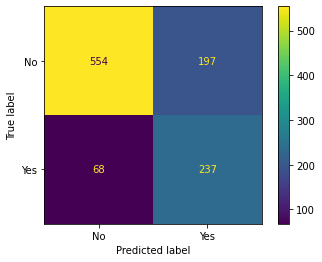

In [350]:
dt_grid_preds = dt_grid.predict(X_val)
print(classification_report(y_val, dt_grid_preds))
plot_confusion_matrix(dt_grid,X_val,y_val, values_format = 'd');

print(f'dt_grid: f2 {fbeta_score(y_val, dt_grid_preds, 2, pos_label="Yes")}')
print(f'dt_grid: accuracy {accuracy_score(y_val, dt_grid_preds)}')
print(f'dt_grid: f1 {f1_score(y_val, dt_grid_preds, pos_label="Yes")}')


AUC score:  0.8191351422147519


Text(0, 0.5, 'TPR')

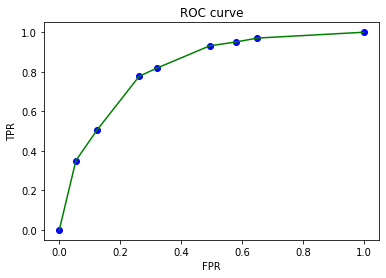

In [295]:
y_pred_proba = dt_grid.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba, pos_label="Yes")
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### Random Forest

              precision    recall  f1-score   support

          No       0.80      0.89      0.84       751
         Yes       0.63      0.45      0.53       305

    accuracy                           0.77      1056
   macro avg       0.72      0.67      0.69      1056
weighted avg       0.75      0.77      0.75      1056

rf: f1 0.5277246653919694
rf: f2 0.4798331015299026


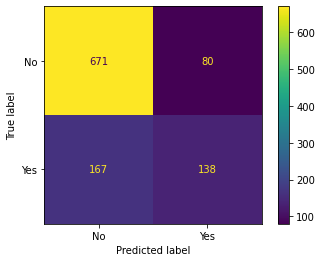

In [348]:
rf = make_pipeline(
    OneHotEncoder(cols = onehot, use_cat_names=True),
    OrdinalEncoder(cols = ordinal),
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
)


rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)

print(classification_report(y_val,rf_preds))
plot_confusion_matrix(rf,X_val,y_val, values_format = 'd');

print(f'rf: f1 {f1_score(y_val, rf_preds, pos_label="Yes")}')

print(f'rf: f2 {fbeta_score(y_val, rf_preds, 2, pos_label="Yes")}')


AUC score:  0.8088821462094258


Text(0, 0.5, 'TPR')

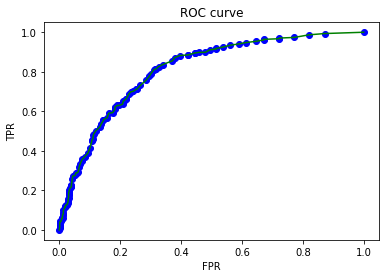

In [298]:
y_pred_proba = rf.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba, pos_label="Yes")
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# 머신러닝 모델 해석



*   PDP, SHAP을 활용하여 최종 모델을 설명합니다
*   시각화는 "설명"이 제일 중요합니다.



              precision    recall  f1-score   support

          No       0.89      0.74      0.81       751
         Yes       0.55      0.78      0.64       305

    accuracy                           0.75      1056
   macro avg       0.72      0.76      0.72      1056
weighted avg       0.79      0.75      0.76      1056

검증 정확도:  0.7490530303030303
f2:  0.7164449818621523


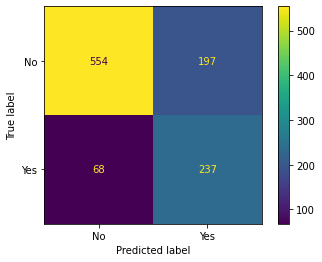

In [347]:
# 최종 모델

final = make_pipeline(
    OneHotEncoder(cols = onehot, use_cat_names=True),
    OrdinalEncoder(cols=ordinal), 
    DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=2,
        max_depth=3,
        min_samples_split=10
      )
)

onehotenc = final.named_steps['onehotencoder']
X_train_encoded = onehotenc.fit_transform(X_train)
X_val_encoded = onehotenc.transform(X_val)

ordinalenc = final.named_steps['ordinalencoder']
X_train_encoded = ordinalenc.fit_transform(X_train_encoded)
X_val_encoded = ordinalenc.transform(X_val_encoded)


final_dt = final.named_steps['decisiontreeclassifier']

final_dt.fit(X_train_encoded, y_train)

final_dt_preds = final_dt.predict(X_val_encoded)
print(classification_report(y_val,final_dt_preds))

plot_confusion_matrix(final_dt, X_val_encoded, y_val, values_format = 'd')

print('검증 정확도: ', final_dt.score(X_val_encoded, y_val))
print('f2: ', fbeta_score(y_val, final_dt_preds, 2, pos_label="Yes"))

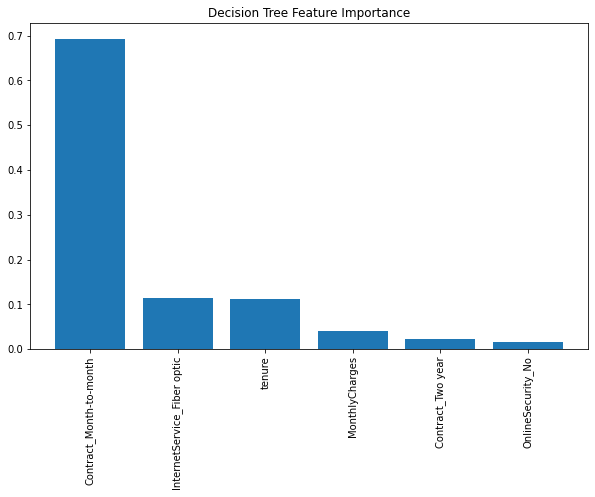

In [318]:
# Final DT Feature Importance
encoded_columns = X_val_encoded.columns
dt_feature_importance = pd.DataFrame(data=final_dt.feature_importances_,index=encoded_columns,columns=['Feature Importance']).sort_values('Feature Importance', ascending=False)
dt_feature_importance = dt_feature_importance[dt_feature_importance['Feature Importance'] > 0]
plt.figure(figsize=(10,6))
plt.title('Decision Tree Feature Importance')
plt.bar(x=dt_feature_importance.index, height=dt_feature_importance['Feature Importance']);
plt.xticks(rotation=90);

In [352]:
dt_feature_importance

,Feature Importance
Contract_Month-to-month,0.693316
InternetService_Fiber optic,0.114244
tenure,0.111593
MonthlyCharges,0.041345
Contract_Two year,0.022327
OnlineSecurity_No,0.017175


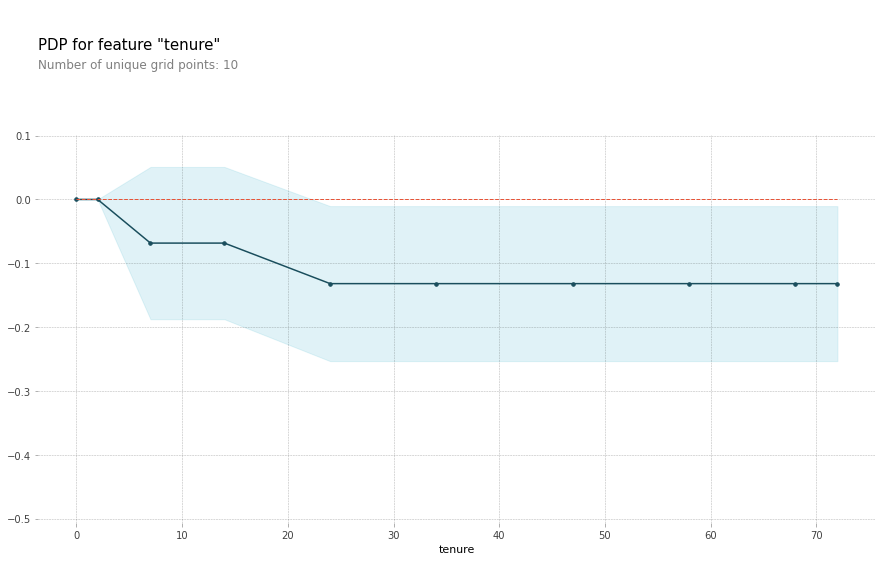

In [319]:
from pdpbox import pdp

feature = 'tenure'

features = X_train_encoded.columns

pdp_dist = pdp.pdp_isolate(model=final_dt, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

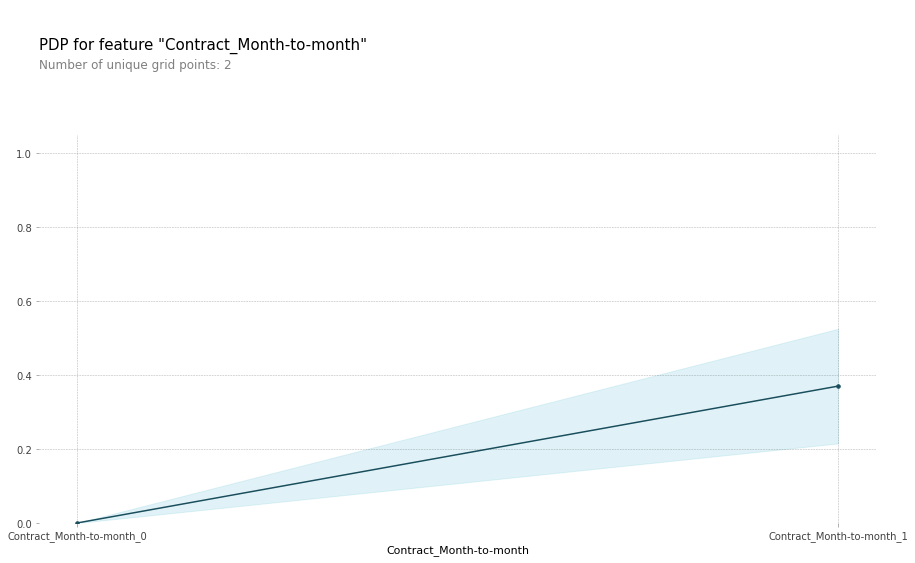

In [304]:
feature = 'Contract_Month-to-month'

pdp_dist = pdp.pdp_isolate(model=final_dt, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

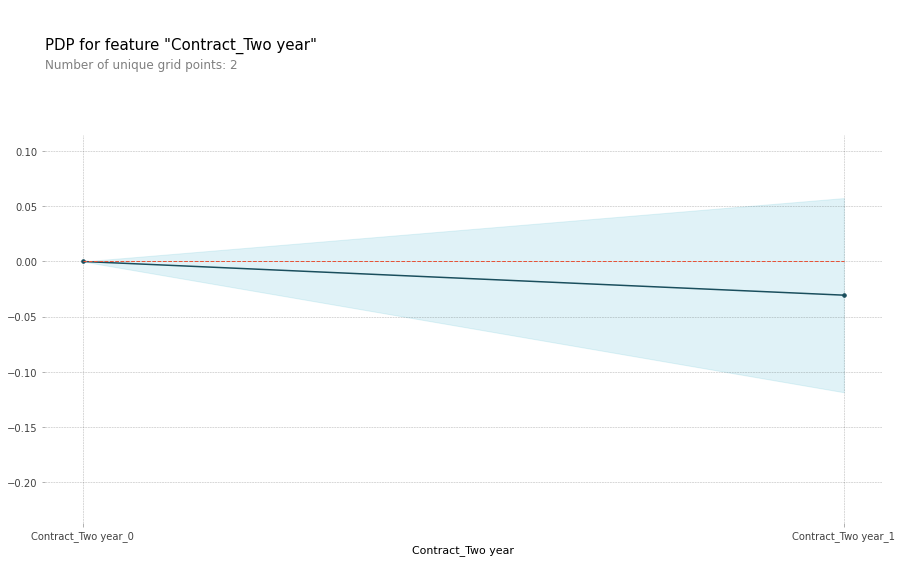

In [305]:
feature = 'Contract_Two year'

pdp_dist = pdp.pdp_isolate(model=final_dt, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

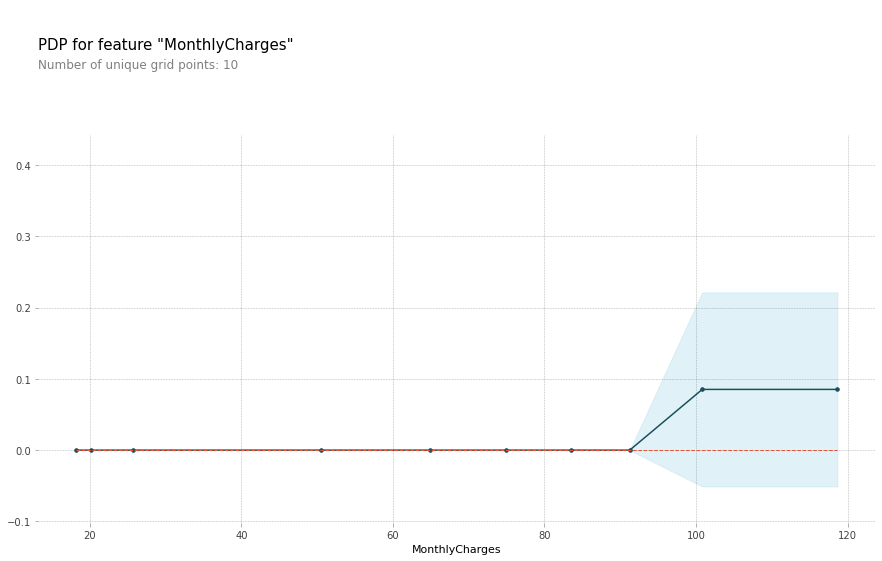

In [314]:
feature = 'MonthlyCharges'

pdp_dist = pdp.pdp_isolate(model=final_dt, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

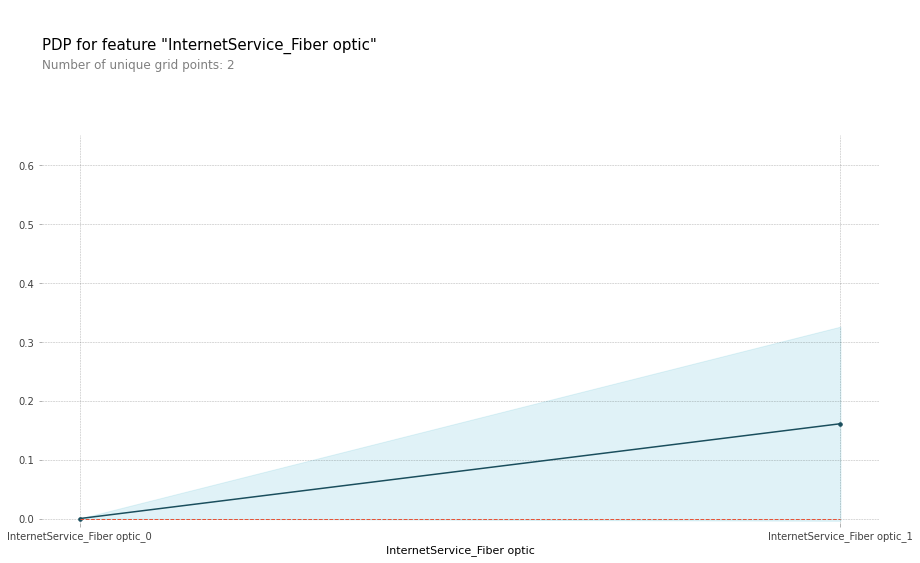

In [320]:
feature = 'InternetService_Fiber optic'

pdp_dist = pdp.pdp_isolate(model=final_dt, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

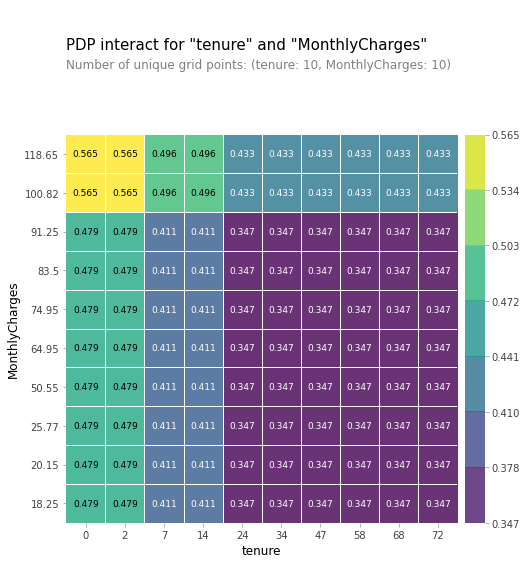

In [315]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['tenure', 'MonthlyCharges']

interaction = pdp_interact(
    model=final_dt, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

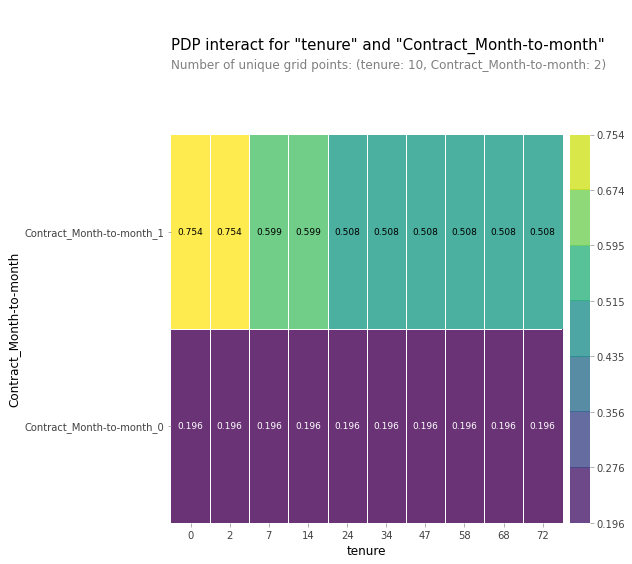

In [353]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['tenure', 'Contract_Month-to-month']

interaction = pdp_interact(
    model=final_dt, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);